# Machine Learning Songs Group Project

## Data Exploration

### Data Types

In [6]:
import pandas as pd
import numpy as np
import re
from IPython.core.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns', None)

summary = pd.read_excel('Songs_2025.xlsx', sheet_name='legend')
summary = summary.rename(columns = {'year': 'Variable', 'year.1': 'Description'})

df = pd.read_excel('Songs_2025.xlsx', sheet_name='spotify songs')
summary['Data Type'] = df.dtypes.values[1:]

md_table = summary.to_markdown(index=False)
display(Markdown(md_table))
display(df.head(1))
display(Markdown('---'))

C:\Users\SABIO\AppData\Local\Temp\ipykernel_14148\3070023069.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, Markdown


| Variable          | Description                                                                                                                                                                  | Data Type   |
|:------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------|
| track_name        | track name                                                                                                                                                                   | object      |
| track_popularity  | track popularity from 0 to 100                                                                                                                                               | int64       |
| album             | album the track appears on                                                                                                                                                   | object      |
| artist_name       | artist name                                                                                                                                                                  | object      |
| artist_genres     | list of the Genres the artist is associated with                                                                                                                             | object      |
| artist_popularity | artist popularity from 0 to 100, being the maximum                                                                                                                           | int64       |
| danceability      | a value of 0.0 is least danceable and 1.0 is most danceable                                                                                                                  | float64     |
| energy            | a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity, being 1.0 the maximum                                                               | float64     |
| key               | The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C,  1 = C♯/D♭,  2 = D  and so on                                              | float64     |
| loudness          | The overall loudness of a track in decibels (dB)                                                                                                                             | float64     |
| mode              | Modality (major or minor) of a track. Major = 1 and minor = 0                                                                                                                | float64     |
| speechiness       | Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. | float64     |
| acousticness      | A confidence measure from 0.0 to 1.0 of whether the track is acoustic                                                                                                        | float64     |
| instrumentalness  | Predicts whether a track contains no vocals                                                                                                                                  | float64     |
| liveness          | Detects the presence of an audience in the recording                                                                                                                         | float64     |
| valence           | a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track                                                                                            | float64     |
| tempo             | The overall estimated tempo of a track in beats per minute (BPM)                                                                                                             | float64     |
| duration_ms       | The duration of the track in milliseconds                                                                                                                                    | float64     |

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2000,7 Days,73,Born to Do It,Craig David,['british soul'],62,0.659,0.812,4.0,87.0,0.0,0.0487,0.23,0.0,0.0951,0.888,83.014,235133.0


---

### Handling Null Values

In [2]:
# Check for Missing Values
pd.DataFrame(df.isnull().sum()).rename(columns = {0:'Number_of_Nulls'})

,Number_of_Nulls
year,0
track_name,0
track_popularity,0
album,0
artist_name,0
artist_genres,0
artist_popularity,0
danceability,1
energy,1
key,1


In [3]:
# Where the missing values are coming from
missing_value = df[df.isnull().any(axis = 1)]
display(missing_value)
display(Markdown('Considering there is only one track with virtually all values missing and an average track popularity, it might make sense to just drop the value and continue with the analysis.'))

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
488,2004,These Words,68,Unwritten,Natasha Bedingfield,['dance pop'; 'pop'; 'post-teen pop'],64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Considering there is only one track with virtually all values missing and an average track popularity, it might make sense to just drop the value and continue with the analysis.

In [4]:
# Dropping the null row
df = df.drop(index = missing_value.index.item())
display(pd.DataFrame(df.isnull().sum()).rename(columns = {0:'Number_of_Nulls'}))
display(Markdown('---'))

,Number_of_Nulls
year,0
track_name,0
track_popularity,0
album,0
artist_name,0
artist_genres,0
artist_popularity,0
danceability,0
energy,0
key,0


---

### Handling Artists Genres & Artist Popularity

Two different approaches. First one takes the first value in the list of artist genres and assumes that it is the most important creating a new column called **dominant_genre_first**. 
  
`Example: ['pop', 'rock'] = pop`  
  
The second approach will split by every word and count the word that appears the most in the list. If there is an instance where it is only one genre but the genre is two words, it will take the second word and if it is only one word, will take just that word.  
  
`Example: ['pop', 'rock', 'country pop'] = pop`   
`Example: ['british soul'] = soul`  
`Example: ['country'] = country`  
  
The third approach takes a predefined list of genres that we are searching for and first tries to match whole genres to the list of predefined genres and if there are no matches then it will try individual words. If no genres are found that match the predefined list then it will return other.  
  
`list = ['hip hop', 'pop', 'rock']`

`Example: ['hip hop', 'german hip hop'] = hip hop`  
`Example: ['punk rock', 'british rock'] = rock`  
`Example: ['r&b', 'trap', 'classic'] = other`

In [41]:
df_genres_testing = df.copy()

In [42]:
# Dominant Genre based on first value in list
def extract_first_genre(genre_str):
    """
    Cleans a list in string format by removing (], [, and ') and then splits by the delimiter ';' to return the
    first value in the list of genres. (Assumes the first genre in the list is most important)
    """
    cleaned_genre = re.sub(r"[\[\]']", "", genre_str).strip()  
    genre_list = cleaned_genre.split(';')
        
    return genre_list[0].strip() 


df_genres_testing['dominant_genre_first'] = df_genres_testing['artist_genres'].apply(extract_first_genre)

In [43]:
# Dominant value based on most occuring word
def clean_and_extract_genre(genre_str):
    """
    Cleans a list in string format by removing (], [, and ') and then splits by the delimiter ';' to return a list of 
    words from the string. If the string only has one genre, it will take the second word as the dominant genre.
    If there are more words, then it will count the individual words and return the word that occurs the most.
    """
    if isinstance(genre_str, str):
        cleaned_genre = re.sub(r"[\[\]']", "", genre_str)
        genre_list = cleaned_genre.split(';')
        
        words = [word for genre in genre_list for word in genre.split()]
        
        #No words
        if not words:
            return 'Unknown'
        
        #One word
        if len(genre_list) == 1:
            return words[1] if len(words) > 1 else words[0]
        
        #Multiple words
        return max(words, key=words.count)

    return 'Unknown'

df_genres_testing['dominant_genre_max'] = df_genres_testing['artist_genres'].apply(clean_and_extract_genre)

In [44]:
# Dominant value based on a predefined word list
target_genres = {'rock', 'pop', 'hip hop', 'jazz', 'electronic', 'classical', 'blues', 
                 'country', 'metal', 'reggae', 'country pop', 'trap', 'house', 'techno'}

def extract_matching_genre(genre_str, target_genres):
    """
    First, splits the lists into individual genres and checks if it matches the predefined list. In the
    case that there are no matches, it will then split the list of genres into individual words and
    check if they match the genre list. This helps to make sure we catch genres like hip hop but also
    genres like country pop.
    """
    if isinstance(genre_str, str):
        cleaned_genre = re.sub(r"[\[\]']", "", genre_str)
        genre_list = [genre.strip().lower() for genre in cleaned_genre.split(';')]
        
        for genre in genre_list:
            if genre in target_genres:
                return genre  
        
        words = [word for genre in genre_list for word in genre.split()]
        
        if "hip" in words and "hop" in words:
            return "hip hop"
        
        for word in words:
            if word in target_genres:
                return word
        
    return 'Other' 


df_genres_testing['matching_genre'] = df_genres_testing['artist_genres'].apply(lambda x: extract_matching_genre(x, target_genres))

---

In [45]:
# Converting Artist popularity into a binary variable
df['artist_popularity_binary'] = df['artist_popularity'].apply(lambda x: 1 if x > 70 else 0)

---

In [47]:
display(df_genres_testing[['dominant_genre_first', 'dominant_genre_max', 'matching_genre']].head())
display(Markdown('---'))

,dominant_genre_first,dominant_genre_max,matching_genre
0,british soul,soul,Other
1,pop rock,rock,pop
2,dance pop,pop,pop
3,alternative metal,punk,rock
4,contemporary country,country,country


---

In [48]:
import re

#creating a function to extract all relevant genre categories from the artist_genre column 

# Define target genres
target_genres = {'rock', 'pop', 'hip hop', 'jazz', 'electronic', 'classical', 'blues', 
                 'country', 'metal', 'reggae', 'country pop', 'trap', 'house', 'techno'} #should we remove country pop??

def extract_all_matching_genres(genre_str, target_genres):
    """
    Extracts ALL matching target genres from the artist_genres column.
    Returns a list of genres found in target_genres.
    If no target genres are found, includes 'Other' in the list.
    """
    if isinstance(genre_str, str):
        # Clean the string (remove brackets, quotes, etc.)
        cleaned_genre = re.sub(r"[\[\]']", "", genre_str)

        # Split into individual genres (assumes comma or semicolon separation)
        genre_list = [genre.strip().lower() for genre in re.split(r'[;,]', cleaned_genre)]

        # Find exact matches in the target genre list
        matching_genres = set()
        for genre in genre_list:
            for target in target_genres:
                if target in genre:  # Check if the target genre is a substring
                    matching_genres.add(target)

        # Handle special case for "hip hop"
        words = set(word for genre in genre_list for word in genre.split())
        if "hip" in words and "hop" in words:
            matching_genres.add("hip hop")

        # Ensure "Other" is included if no target genres match
        if not matching_genres:
            matching_genres.add("Other")

        return list(matching_genres)

    return ["Other"]

# Apply function to create the new column
df['artist_genre_categories'] = df['artist_genres'].apply(lambda x: extract_all_matching_genres(x, target_genres))


# Display the updated DataFrame using Pandas
df[['artist_genres', 'artist_genre_categories']].head(2)  # Show first 10 rows

,artist_genres,artist_genre_categories
0,['british soul'],[Other]
1,['pop rock'],"[pop, rock]"


In [49]:
#Creating flag variables for all genre categories 

# Convert 'target_artist_genres_shown' into individual binary flag columns
df_flags = df['artist_genre_categories'].apply(lambda x: pd.Series({genre: 1 for genre in x}))

# Fill NaN values with 0 (indicating absence of a genre)
df_flags = df_flags.fillna(0).astype(int)

# Drop existing genre flag columns to avoid duplication
df = df.drop(columns=df_flags.columns, errors='ignore')

# Join the new flag variables back to the original DataFrame
df = df.join(df_flags)

df.iloc[:, -15:]

,artist_genre_categories,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
0,[Other],1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[pop, rock]",0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,[pop],0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,"[metal, pop, rock]",0,1,1,1,0,0,0,0,0,0,0,0,0,0
4,[country],0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,[Other],1,0,0,0,0,0,0,0,0,0,0,0,0,0
2296,[pop],0,1,0,0,0,0,0,0,0,0,0,0,0,0
2297,"[house, pop]",0,1,0,0,0,1,0,0,0,0,0,0,0,0
2298,[pop],0,1,0,0,0,0,0,0,0,0,0,0,0,0


### Unique Values

In [5]:
# Drop the original genre column
df = df.drop(columns='artist_genre_categories')

rows, columns = df.shape 
display(Markdown(f'''The dataset has **{rows} rows** and **{columns} columns** including the ones we created. 
                 When analyzing the unique values, we can see that our new columns for extracting the
                 dominant genre decrease the amount of unique categories that we have to work with. 
                 The number of unique values include:'''))

unique_values = pd.DataFrame(df.nunique())
unique_values = unique_values.rename(columns = {0: 'Unique Values'})
display(unique_values)
display(Markdown('---'))

KeyError: "['artist_genre_categories'] not found in axis"

### Basic Statistics

#### Map Values for Readability

In [52]:
# # Convert categorical numeric columns to categorical type
# df_genres_testing['mode'] = df_genres_testing['mode'].astype('category')
# df_genres_testing['key'] = df_genres_testing['key'].astype('category')
# df_genres_testing['year'] = df_genres_testing['year'].astype('category')
# df_genres_testing['dominant_genre_first'] = df_genres_testing['dominant_genre_first'].astype('category')
# df_genres_testing['dominant_genre_max'] = df_genres_testing['dominant_genre_max'].astype('category')

pitch_class_map = {
    0: "C",
    1: "C#/D♭",
    2: "D",
    3: "D#/E♭",
    4: "E",
    5: "F",
    6: "F#/G♭",
    7: "G",
    8: "G#/A♭",
    9: "A",
    10: "A#/B♭",
    11: "B"
}

mode_class_map = {
    1: 'major',
    0: 'minor'
}

df_genres_testing['pitch_class'] = df_genres_testing['key'].map(pitch_class_map).astype('category')
df_genres_testing['mode_class'] = df_genres_testing['mode'].map(mode_class_map).astype('category')

#### Numeric Statistics (Mean, Median, Mode)

In [53]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,2299.0,2011.003045,6.634528,2000.000000,2005.00000,2011.0000,2017.000000,2022.000
track_popularity,2299.0,70.944759,12.294047,0.000000,66.00000,72.0000,79.000000,100.000
artist_popularity,2299.0,72.873423,12.180506,29.000000,65.00000,74.0000,82.000000,100.000
danceability,2299.0,0.660116,0.141137,0.162000,0.57200,0.6710,0.759500,0.975
energy,2299.0,0.693047,0.164838,0.051900,0.58600,0.7120,0.820000,0.999
key,2299.0,5.277947,3.628494,0.000000,2.00000,5.0000,8.000000,11.000
loudness,2299.0,73.006960,15.643937,-56.000000,63.00000,74.0000,83.000000,132.000
mode,2299.0,0.598521,0.490304,0.000000,0.00000,1.0000,1.000000,1.000
speechiness,2299.0,0.097795,0.092445,0.022500,0.03800,0.0568,0.115500,0.576
acousticness,2299.0,0.157689,0.203844,0.000013,0.01650,0.0689,0.223000,0.978


In [54]:
print('Timeline:')
#print(df['year'].value_counts())

min_year = min(df['year'])
max_year = max(df['year'])
average = df['year'].value_counts().mean()

print(f'Dataset includes songs in the range {min_year}-{max_year} and is evenly split at {average} songs per year')

Timeline:
Dataset includes songs in the range 2000-2022 and is evenly split at 99.95652173913044 songs per year


In [55]:
print('Value Counts for Mode:')
print(df_genres_testing['mode_class'].value_counts())

Value Counts for Mode:
mode_class
major    1376
minor     923
Name: count, dtype: int64


In [56]:
print('Value Counts for Pitch:')
print(df_genres_testing['pitch_class'].value_counts())

Value Counts for Pitch:
pitch_class
C#/D♭    297
C        253
G        225
B        219
F        201
D        189
G#/A♭    183
A        183
F#/G♭    177
E        152
A#/B♭    147
D#/E♭     73
Name: count, dtype: int64


In [57]:
print('Top 5 Genres for Dominant Genre (First)')
print(df_genres_testing['dominant_genre_first'].value_counts().head(5))

Top 5 Genres for Dominant Genre (First)
dominant_genre_first
dance pop            427
pop                  256
atl hip hop           90
alternative metal     74
boy band              53
Name: count, dtype: int64


In [58]:
print('Top 5 Genres for Dominant Genre (Max)')
print(df_genres_testing['dominant_genre_max'].value_counts().head(5))

Top 5 Genres for Dominant Genre (Max)
dominant_genre_max
pop         943
hip         211
rap         209
rock        129
canadian     53
Name: count, dtype: int64


In [59]:
print('Top 5 Genres for (Predefined List)')
print(df_genres_testing['matching_genre'].value_counts().head(5))

Top 5 Genres for (Predefined List)
matching_genre
pop        1292
hip hop     363
Other       222
rock        165
trap        100
Name: count, dtype: int64


---

#### Histogram of Variables

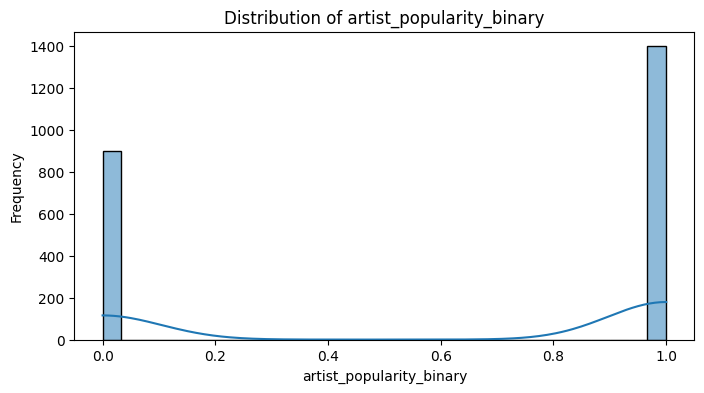

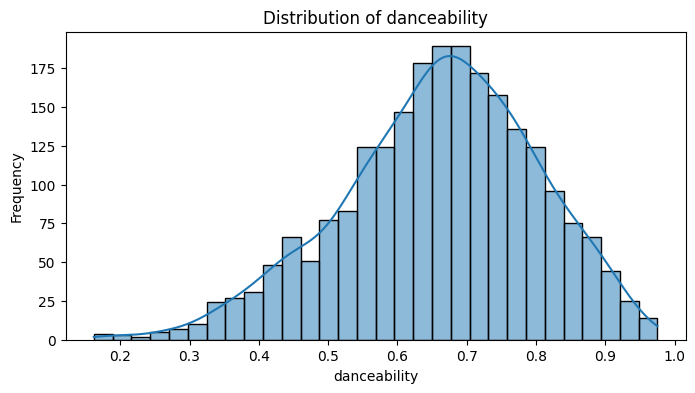

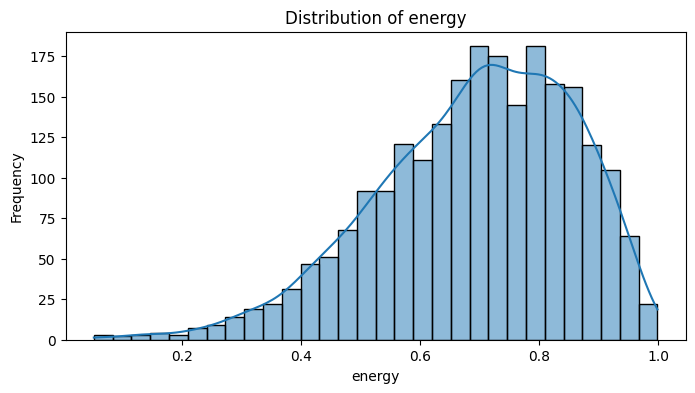

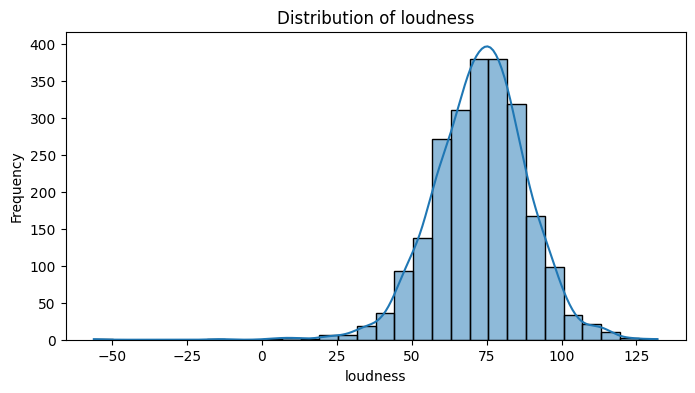

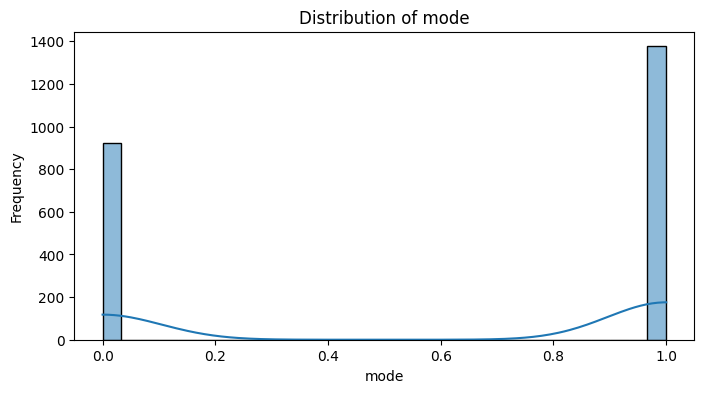

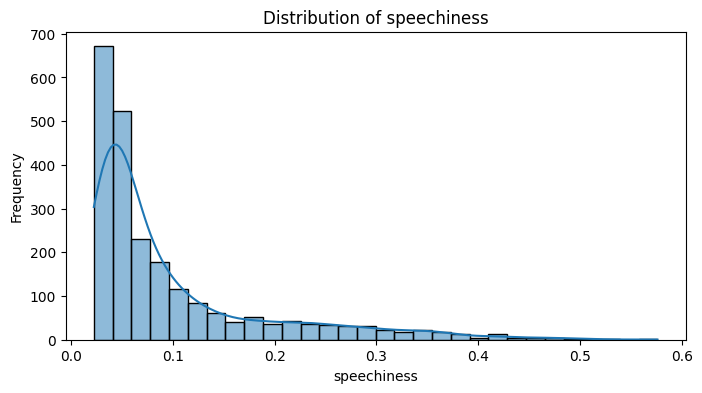

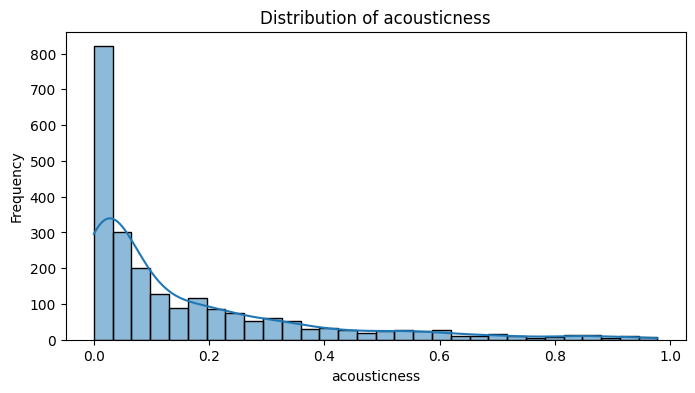

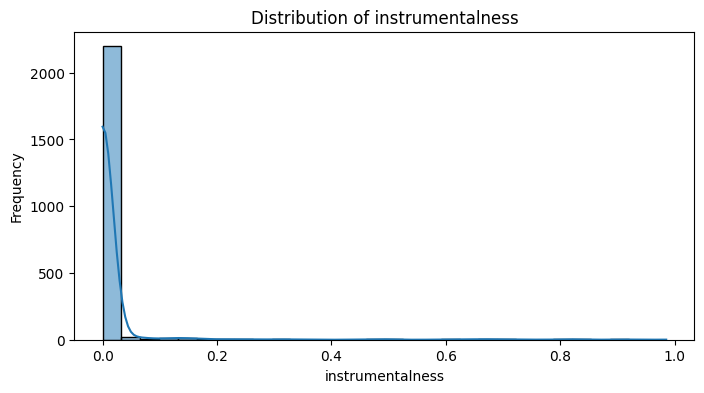

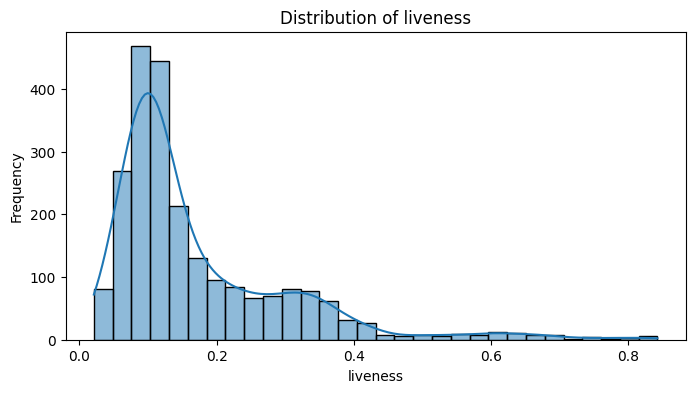

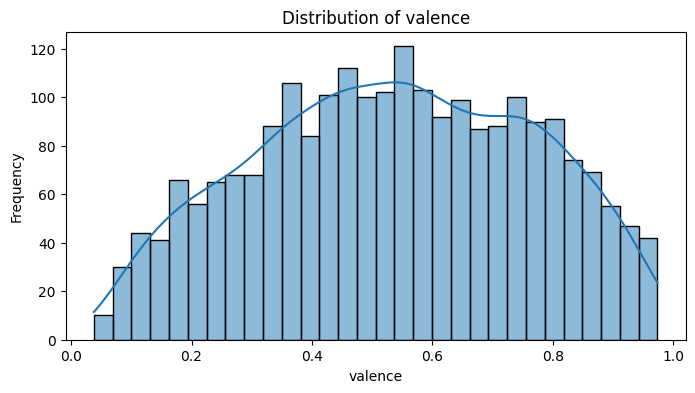

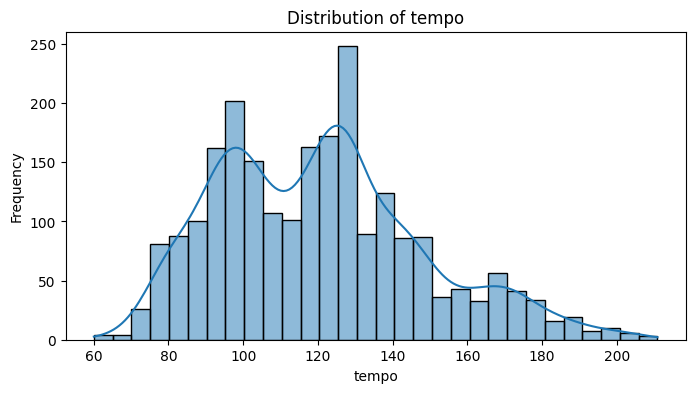

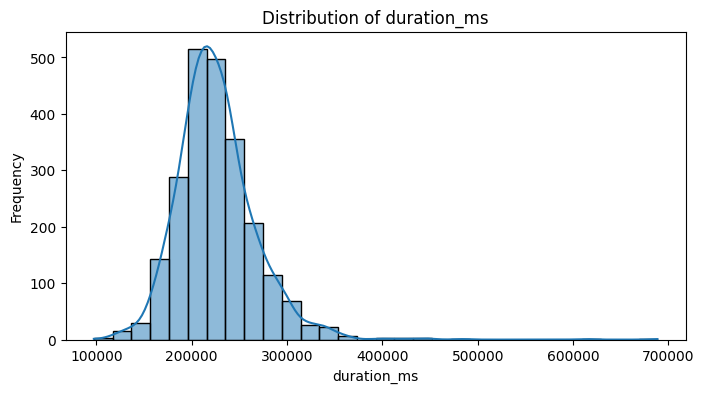

In [60]:
# columns_to_plot = [
#     'track_popularity', 'artist_popularity_binary', 'danceability', 'energy', 'key', 
#     'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
#     'liveness', 'valence', 'tempo', 'duration_ms'
# ]

columns_to_plot = [
    'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]  

for col in columns_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True)  # KDE=True adds density curve
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

There are extreme outliers which may pose some problems  

---

#### Correlation Matrix

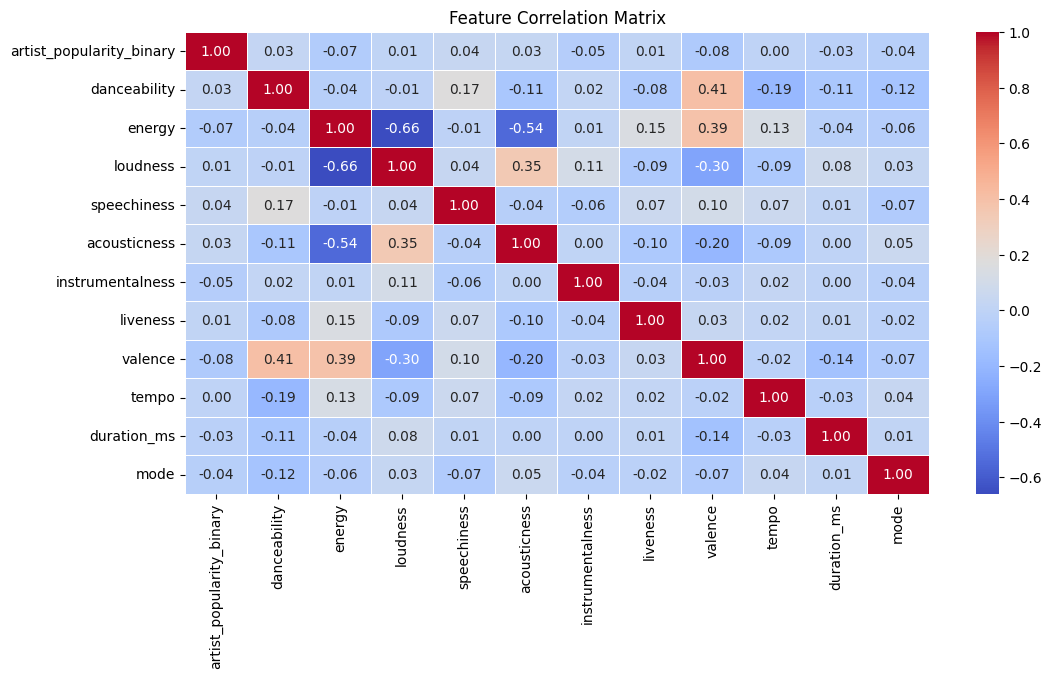

In [61]:
columns_to_plot = [
    'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'mode'
]

corr_matrix = df[columns_to_plot].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [62]:
# Find highly correlated pairs
correlation_threshold = 0.3
high_corr_pairs = []

for col in corr_matrix.columns:
    for index in corr_matrix.index:
        if col != index and abs(corr_matrix.loc[col, index]) > correlation_threshold:
            high_corr_pairs.append((col, index))

print(f"Highly Correlated Features {correlation_threshold}:", high_corr_pairs)

Highly Correlated Features 0.3: [('danceability', 'valence'), ('energy', 'loudness'), ('energy', 'acousticness'), ('energy', 'valence'), ('loudness', 'energy'), ('loudness', 'acousticness'), ('acousticness', 'energy'), ('acousticness', 'loudness'), ('valence', 'danceability'), ('valence', 'energy')]


In [63]:
df.columns

Index(['year', 'track_name', 'track_popularity', 'album', 'artist_name',
       'artist_genres', 'artist_popularity', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms',
       'artist_popularity_binary', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'],
      dtype='object')

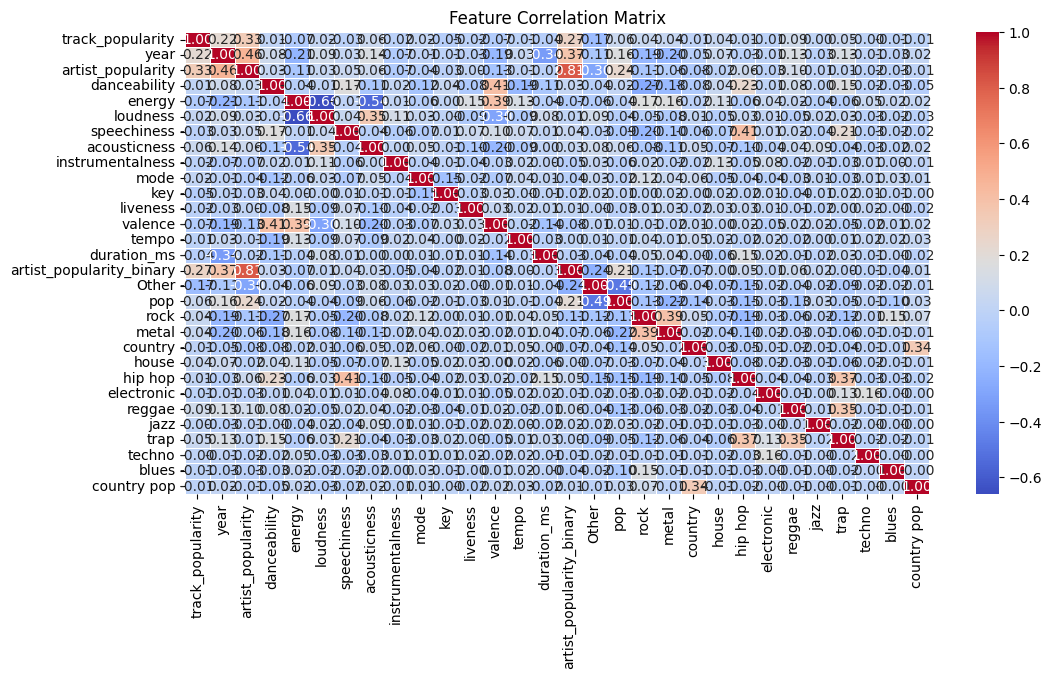

In [64]:
columns_to_plot = [
     'track_popularity', 'year', 'artist_popularity', 'danceability', 'energy', 
       'loudness', 'speechiness', 'acousticness', 'instrumentalness','mode', 'key',
       'liveness', 'valence', 'tempo', 'duration_ms', 'artist_popularity_binary',
       'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

corr_matrix = df[columns_to_plot].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [64]:
df.dtypes

year                        category
track_name                    object
track_popularity               int64
album                         object
artist_name                   object
artist_genres                 object
artist_popularity              int64
danceability                 float64
energy                       float64
key                         category
loudness                     float64
mode                        category
speechiness                  float64
acousticness                 float64
instrumentalness             float64
liveness                     float64
valence                      float64
tempo                        float64
duration_ms                  float64
dominant_genre_first        category
dominant_genre_max          category
matching_genre                object
artist_popularity_binary       int64
artist_genre_categories       object
Other                          int32
rock                           int32
pop                            int32
m

In [65]:
# Find highly correlated pairs to track_popularity to see if there are highly correlated variables

# Set the correlation threshold
correlation_threshold = 0.1

# Get the correlations with 'track_popularity' and filter based on the threshold
high_corr = corr_matrix['track_popularity'].abs() > correlation_threshold

# Exclude self-correlation and get the index (column names) of highly correlated features
high_corr_features = corr_matrix['track_popularity'][high_corr & (corr_matrix.index != 'track_popularity')]

print("Highly Correlated Features with 'track_popularity':")
print(high_corr_features)


Highly Correlated Features with 'track_popularity':
year                        0.218524
artist_popularity           0.331029
artist_popularity_binary    0.273003
Other                      -0.166913
Name: track_popularity, dtype: float64


In [66]:
#dropping the unnecessary categorical columns 
columns_to_drop= ['track_name', 'album', 'artist_name',
       'artist_genres', 'artist_genre_categories','dominant_genre_first','dominant_genre_max','matching_genre','pitch_class','mode_class']

print("Dropping the following columns: %s" % columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

Dropping the following columns: ['track_name', 'album', 'artist_name', 'artist_genres', 'artist_genre_categories', 'dominant_genre_first', 'dominant_genre_max', 'matching_genre', 'pitch_class', 'mode_class']


KeyError: "['artist_genre_categories', 'dominant_genre_first', 'dominant_genre_max', 'matching_genre', 'pitch_class', 'mode_class'] not found in axis"

In [67]:
df.head()

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,artist_popularity_binary,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
0,2000,7 Days,73,Born to Do It,Craig David,['british soul'],62,0.659,0.812,4.0,87.0,0.0,0.0487,0.230000,0.0,0.0951,0.888,83.014,235133.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2000,Absolutely (Story of a Girl) - Radio Mix,69,The Madding Crowd,Nine Days,['pop rock'],49,0.481,0.940,7.0,71.0,1.0,0.0660,0.000891,0.0,0.0939,0.660,96.493,189333.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,2000,Against All Odds (Take A Look at Me Now) - Mar...,61,Against All Odds (Take A Look at Me Now) EP,Mariah Carey,['dance pop'; 'pop'; 'urban contemporary'],76,0.542,0.498,1.0,80.0,1.0,0.0299,0.490000,0.0,0.1010,0.218,117.763,201933.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2000,All The Small Things,84,Enema Of The State,blink-182,['alternative metal'; 'modern rock'; 'pop punk...,75,0.434,0.897,0.0,69.0,1.0,0.0488,0.010300,0.0,0.6120,0.684,148.726,167067.0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0
4,2000,Amazed,72,Lonely Grill,Lonestar,['contemporary country'; 'country'; 'country r...,57,0.561,0.543,1.0,92.0,1.0,0.0324,0.260000,0.0,0.1240,0.243,139.803,240867.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## Segmentation (Groups of Similar Songs)

### Variable Analysis

Variables to be excluded from Clustering

| **Variable**         | **Reason for Exclusion** |
|----------------------|-------------------------|
| **year**            | Numerical, but not continuous (songs from 2000 and 2023 are not necessarily similar). |
| **track_name**      | Unique for each song → Categorical, not useful for clustering. |
| **album**          | Categorical → Songs in the same album don’t necessarily belong to the same cluster. |
| **artist_name**     | Categorical → Each artist is unique, not useful for clustering. |
| **artist_genres**   | Unless we use the matching function, dummy variables will create redundancy |
| **track_popularity** | We want to explain clusters using this, not use it to create clusters. |
  
Feature Selection for Clustering:  

| **Variable**                 | **Keep or Remove?** | **Reason** |
|------------------------------|---------------------|------------|
| **artist_popularity_binary** | Keep               | Useful to differentiate popular vs. less popular artists. |
| **danceability**             | Keep               | Describes how easy it is to dance to a song. |
| **energy**                   | Keep               | Measures intensity and activity of the song. |
| **key**                      | Remove              | Numerical but already simplified and represented with mode |
| **loudness**                 | Keep               | Helps distinguish between soft and loud tracks. |
| **mode**                     | Maybe              | Binary (Major=1, Minor=0) |
| **speechiness**              | Keep               | Helps separate spoken-word-heavy songs from musical ones. |
| **acousticness**             | Keep               | Measures how acoustic a track sounds. |
| **instrumentalness**         | Keep               | Helps distinguish instrumental tracks from vocal ones. |
| **liveness**                 | Keep               | Measures audience presence (useful for live vs. studio recordings). |
| **valence**                  | Keep               | Measures how positive a song feels. |
| **tempo (BPM)**              | Keep               | Describes song pacing, but needs standardization to prevent bias. |
| **duration_ms**              | Maybe              | Songs vary widely in length → Might skew clustering unless normalized. |

---


### Kmeans Brute Force

In [ ]:
def find_highly_correlated_features(df_of_features, threshold):
    """
    Uses correlation matrix columns and index to find highly correlated variable pairs and returns
    a list of tuples where the correlated pair only occurs once.
    """
    corr_matrix = df_of_features.corr()
    high_corr_pairs = set()

    for col in corr_matrix.columns:
        for index in corr_matrix.index:
            if col != index and abs(corr_matrix.loc[col, index]) > threshold:
                high_corr_pairs.add(tuple(sorted((col, index))))

    return list(high_corr_pairs)

def generate_feature_combinations(features, high_corr_pairs):
    """
    Generates all valid variable sets ensuring that no correlated pair appears together.
    Also generates variable reduction subsets without testing an exponential number of combinations.
    Returns a list of lists including both generations above.
    """
    feature_sets = []

    if high_corr_pairs:
        for subset in itertools.product(*[[pair[0], pair[1]] for pair in high_corr_pairs]):
            reduced_features = set(features) - set(subset)

            is_valid = all(not (pair[0] in reduced_features and pair[1] in reduced_features) for pair in high_corr_pairs)

            if is_valid and reduced_features not in feature_sets:
                feature_sets.append(reduced_features)
    else:
        # If no correlated variables, just use the full list of variables
        feature_sets.append(set(features))

    # Feature reduction
    final_feature_sets = set()

    for feature_set in feature_sets:
        feature_list = list(feature_set)
        
        for r in range(len(feature_list) - 2, len(feature_list) + 1):  # Test near-complete sets only
            for subset in itertools.combinations(feature_list, r):
                final_feature_sets.add(subset)

    return [list(s) for s in final_feature_sets]

def run_kmeans(df, feature_sets, k_range):
    """
    Runs K-Means clustering for multiple feature sets, recording optimal k and silhouette scores.
    """
    results = []

    # Kmeans
    for features in feature_sets:
        X = df[list(features)] 
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        inertia = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

        optimal_k = k_range[np.argmin(np.gradient(inertia))]

        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)

        results.append({
            'features_used': list(features),
            'optimal_k': optimal_k,
            'silhouette_score': silhouette
        })

    return results

# Initial Parameters
correlation_thresholds = [0.7, 0.5, 0.3]  # Thresholds for correlation between variables
k_range = range(2, 11)  # Range for number of clusters to test

# Original feature list
features = [
    'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]  

final_results = []

for threshold in correlation_thresholds:
    print(f"\n🔹 Running K-Means Optimization for Correlation Threshold: {threshold}")

    # Find highly correlated variables
    high_corr_pairs = find_highly_correlated_features(df[features], threshold)

    # Generate Sets - without corr pairs and variable reduction
    feature_sets = generate_feature_combinations(features, high_corr_pairs)

    # Run K-Means
    results = run_kmeans(df, feature_sets, k_range)

    # Results
    for res in results:
        res['correlation_threshold'] = threshold
        final_results.append(res)

# Results DataFrame
df_results = pd.DataFrame(final_results)
df_results.to_csv('kmeans_results.csv')
display(Markdown(df_results.sort_values(by = ['silhouette_score'], ascending = False).head().to_markdown()))


🔹 Running K-Means Optimization for Correlation Threshold: 0.7


c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

KeyboardInterrupt: 

In [68]:
results_csv = pd.read_csv('kmeans_results.csv')
display(Markdown(results_csv.loc[results_csv.groupby('optimal_k')['silhouette_score'].idxmax()].sort_values(by='optimal_k').to_markdown()))
display(Markdown('---'))

|     |   Unnamed: 0 | features_used                                                                                                        |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:---------------------------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 438 |          438 | ['instrumentalness', 'tempo', 'duration_ms', 'liveness', 'speechiness']                                              |           2 |           0.693124 |                     0.3 |
| 416 |          416 | ['instrumentalness', 'duration_ms', 'liveness', 'speechiness', 'mode']                                               |           3 |           0.332866 |                     0.3 |
| 100 |          100 | ['artist_popularity_binary', 'valence', 'instrumentalness', 'tempo', 'duration_ms', 'energy', 'speechiness', 'mode'] |           4 |           0.153438 |                     0.5 |

---

### Trying out the Highest Silhouette segmentations (Optimal_K = 2)

In [69]:
results_csv = pd.read_csv('kmeans_results.csv')
display(Markdown(results_csv.sort_values(by=['silhouette_score'], ascending=False).head(10).to_markdown()))

|     |   Unnamed: 0 | features_used                                                                                       |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:----------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 438 |          438 | ['instrumentalness', 'tempo', 'duration_ms', 'liveness', 'speechiness']                             |           2 |           0.693124 |                     0.3 |
| 561 |          561 | ['instrumentalness', 'tempo', 'duration_ms', 'energy', 'liveness', 'speechiness']                   |           2 |           0.654633 |                     0.3 |
| 619 |          619 | ['valence', 'duration_ms', 'instrumentalness', 'tempo', 'liveness', 'speechiness']                  |           2 |           0.653148 |                     0.3 |
| 367 |          367 | ['loudness', 'danceability', 'instrumentalness', 'tempo', 'duration_ms', 'liveness', 'speechiness'] |           2 |           0.623068 |                     0.3 |
| 603 |          603 | ['danceability', 'instrumentalness', 'tempo', 'duration_ms', 'energy', 'liveness', 'speechiness']   |           2 |           0.621768 |                     0.3 |
| 416 |          416 | ['instrumentalness', 'duration_ms', 'liveness', 'speechiness', 'mode']                              |           3 |           0.332866 |                     0.3 |
| 483 |          483 | ['artist_popularity_binary', 'instrumentalness', 'duration_ms', 'liveness', 'speechiness']          |           2 |           0.308998 |                     0.3 |
| 374 |          374 | ['artist_popularity_binary', 'instrumentalness', 'tempo', 'speechiness', 'mode']                    |           3 |           0.304449 |                     0.3 |
| 545 |          545 | ['artist_popularity_binary', 'instrumentalness', 'tempo', 'liveness', 'speechiness']                |           2 |           0.301023 |                     0.3 |
| 579 |          579 | ['instrumentalness', 'tempo', 'liveness', 'speechiness', 'mode']                                    |           2 |           0.300882 |                     0.3 |

In [70]:
df['year'] = df['year'].astype('int64')

In [71]:
#segmentation 1
features = ['instrumentalness', 'tempo', 'duration_ms', 'liveness', 'speechiness']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=2: 0.693


In [72]:
# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_1_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_1_output

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


In [ ]:
#segmentation 2 
features = 	['instrumentalness', 'tempo', 'duration_ms', 'energy', 'liveness', 'speechiness']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_2_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_2_output #same output as seg 1 


c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=2: 0.655


,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


In [74]:
#segmentation 3
features = 	['valence', 'duration_ms', 'instrumentalness', 'tempo', 'liveness', 'speechiness']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_2_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_2_output #same output as seg 1 and 2 - no new insights 

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=2: 0.653


,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


In [75]:
#segmentation 4
features = 	['loudness', 'danceability', 'instrumentalness', 'tempo', 'duration_ms', 'liveness', 'speechiness']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_2_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_2_output #same output as seg 1 and 2 - no new insights 

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=2: 0.623


,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


In [76]:
#segmentation 5
features = 	['danceability', 'instrumentalness', 'tempo', 'duration_ms', 'energy', 'liveness', 'speechiness']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_2_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_2_output #same output as seg 1 and 2 - no new insights 

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=2: 0.622


,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


From what we can see, all optimal segmentations with 2 clusters provide the same 2 groups 

In [77]:
#segmentation 6
features = 	['danceability', 'instrumentalness', 'tempo', 'duration_ms', 'energy', 'liveness', 'speechiness']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_2_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_2_output #same output as seg 1 and 2 - no new insights 

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=2: 0.622


,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


### OTHER

| **Feature**                  | **Cluster 0** | **Cluster 1** | **Interpretation** |
|------------------------------|---------------------|---------------------|--------------------|
| **track_popularity**         | 70.98              | 68.78              | Slightly higher in Cluster 0, but not a huge difference. |
| **artist_popularity_binary** | 0.61               | 0.44               | Cluster 0 has more songs from popular artists. |
| **danceability**             | 0.66               | 0.69               | Cluster 1 is slightly more danceable. |
| **energy**                   | 0.69               | 0.70               | No major difference. |
| **loudness**                 | 72.85 dB           | 83.84 dB           | Cluster 1 is much louder! |
| **mode (Major=1, Minor=0)**  | 0.60               | 0.44               | Cluster 0 has more major-key songs, Cluster 1 has more minor-key songs. |
| **speechiness**              | 0.098              | 0.061              | Cluster 0 has more speech-like elements. |
| **acousticness**             | 0.158              | 0.155              | Almost identical, not driving cluster separation. |
| **instrumentalness**         | 0.004              | 0.671              | Cluster 1 has significantly more instrumental tracks! |
| **liveness**                 | 0.173              | 0.142              | Cluster 0 has slightly more live recordings. |
| **valence**                  | 0.536              | 0.490              | Cluster 0 has more "positive" music. |
| **tempo**                    | 120.48 BPM         | 122.80 BPM         | Cluster 1 has slightly faster songs. |
| **duration_ms**              | 226,118 ms (~3m 46s) | 220,028 ms (~3m 40s) | Cluster 0 has slightly longer songs. |

High silhouette score of (0.693) however the seperation is broad and may oversimplify the grouping of songs. Cluster 0 includes more vocal dominant and popular songs in the major key while Cluster 1 includes more instrumental dominant and loud songs in the minor key. 

---

### Highest Silhouette (Optimal K = 3)

In [78]:
results_csv = pd.read_csv('kmeans_results.csv')
display(Markdown(results_csv[results_csv['optimal_k'] > 2].sort_values(by=['silhouette_score'], ascending=False).head(1).to_markdown()))

|     |   Unnamed: 0 | features_used                                                          |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:-----------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 416 |          416 | ['instrumentalness', 'duration_ms', 'liveness', 'speechiness', 'mode'] |           3 |           0.332866 |                     0.3 |

In [79]:
features = ['mode', 'liveness', 'instrumentalness', 'speechiness', 'duration_ms']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=3: 0.333


In [80]:
df.columns

Index(['year', 'track_popularity', 'artist_popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'artist_popularity_binary', 'Other', 'rock', 'pop', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop', 'audio_cluster'],
      dtype='object')

In [83]:
# Select only specific numerical columns for comparison
numerical_features = [
   'year', 'track_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms',
]
df.groupby('audio_cluster')[numerical_features].mean()

,year,track_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
audio_cluster,,,,,,,,,,,,,
0,2011.002075,70.107884,0.645228,0.692575,0.700073,73.056017,0.241003,0.140888,0.001906,0.256783,0.566241,122.924405,230022.659751
1,2011.065546,71.209524,0.601681,0.650838,0.691085,72.799440,0.059783,0.162271,0.005195,0.150440,0.527505,119.820207,225063.965266
2,2007.531250,68.781250,0.437500,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.218750


| **Feature**                   | **Cluster 0** | **Cluster 1** | **Cluster 2** | **Interpretation** |
|--------------------------------|---------------------|---------------------|---------------------|--------------------|
| **track_popularity**          | 70.11              | 71.21              | 68.78              | No major difference. |
| **artist_popularity_binary**  | 0.645              | 0.602              | 0.438              | Cluster 2 has fewer popular artists. |
| **danceability**              | 0.693              | 0.651              | 0.689              | Cluster 1 is less danceable. |
| **energy**                    | 0.70               | 0.69               | 0.70               | No significant difference. |
| **loudness**                  | 73.06 dB           | 72.80 dB           | 83.84 dB           | Cluster 2 is significantly louder! |
| **mode (Major=1, Minor=0)**   | 0.48               | 0.63               | 0.44               | Cluster 1 has more major-key songs, Cluster 2 has more minor-key songs. |
| **speechiness**               | 0.241              | 0.060              | 0.061              | Cluster 0 has much higher speechiness |
| **acousticness**              | 0.141              | 0.162              | 0.155              | No major difference. |
| **instrumentalness**          | 0.002              | 0.005              | 0.671              | Cluster 2 contains instrumental tracks |
| **liveness**                  | 0.257              | 0.150              | 0.142              | Cluster 0 has more live recordings. |
| **valence**                   | 0.566              | 0.528              | 0.490              | Cluster 0 is happier, Cluster 2 is less positive. |
| **tempo**                     | 122.92 BPM         | 119.82 BPM         | 122.80 BPM         | Cluster 1 has slower songs. |
| **duration_ms**               | 230,022 ms (~3m 50s) | 225,063 ms (~3m 45s) | 220,028 ms (~3m 40s) | Cluster 0 has longer songs. |  
  
Lower silhouette score at (0.333) so the clusters are less well-defined and some data may be overlapping however when comparing variables it shows some more significant differences between clusters. Cluster 0 includes speech heavy / lively music, Cluster 1 has Major Key / less danceable / softer music, while Cluster 2 has Instrumental / Louder Music.

---

### Highest Silhouette (Optimal K = 4)

In [84]:
results_csv = pd.read_csv('kmeans_results.csv')
display(Markdown(results_csv[results_csv['optimal_k'] > 3].sort_values(by=['silhouette_score'], ascending=False).head(1).to_markdown()))

|     |   Unnamed: 0 | features_used                                                                                                        |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:---------------------------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 100 |          100 | ['artist_popularity_binary', 'valence', 'instrumentalness', 'tempo', 'duration_ms', 'energy', 'speechiness', 'mode'] |           4 |           0.153438 |                     0.5 |

In [85]:
features = ['artist_popularity_binary', 'mode', 'valence', 'energy', 'duration_ms', 'instrumentalness', 'speechiness', 'tempo']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=4: 0.153


In [87]:
# Select only specific numerical columns for comparison
numerical_features = [
    'track_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 
]
df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
audio_cluster,,,,,,,,,,,,
0,71.029619,0.571227,0.656907,0.787898,66.589563,0.066576,0.094596,0.011641,0.178470,0.645406,124.674358,217282.561354
1,71.918089,0.643345,0.611137,0.528196,83.534130,0.056898,0.282058,0.015276,0.150255,0.307408,115.911840,240125.334471
2,70.623762,0.603960,0.685236,0.743018,69.636492,0.077149,0.120941,0.018467,0.179031,0.594295,119.290156,221167.319661
3,69.585859,0.639731,0.704616,0.672923,75.579125,0.302165,0.150394,0.004671,0.187506,0.580195,122.564057,230703.454545


| **Feature**                     | **Cluster 0** | **Cluster 1** | **Cluster 2** | **Cluster 3** | **Interpretation** |
|----------------------------------|--------------|--------------|--------------|--------------|--------------------|
| **track_popularity**            | 71.03        | 71.92        | 70.62        | 69.59        | No strong popularity pattern across clusters. |
| **artist_popularity_binary**    | 0.571        | 0.643        | 0.604        | 0.640        | No strong separation between popular and less popular artists. |
| **danceability**                | 0.657        | 0.611        | 0.685        | 0.705        | Cluster 3 is **most danceable**, Cluster 1 is **least danceable**. |
| **energy**                      | 0.788        | 0.528        | 0.743        | 0.673        | Cluster 1 has **significantly lower energy** (possibly softer songs). |
| **loudness**                    | 66.59 dB     | 83.53 dB     | 69.64 dB     | 75.58 dB     | **Cluster 1 is much louder!** |
| **mode (Major=1, Minor=0)**     | 1.000        | 0.845        | 0.000        | 0.579        | Cluster 2 is **exclusively minor-key**, Cluster 0 is **exclusively major-key**. |
| **speechiness**                 | 0.067        | 0.057        | 0.077        | 0.302        | **Cluster 3 has very high speechiness (rap/spoken word cluster?)**. |
| **acousticness**                | 0.095        | 0.282        | 0.121        | 0.150        | Cluster 1 has **the most acoustic music**. |
| **instrumentalness**            | 0.012        | 0.015        | 0.018        | 0.005        | No major difference. |
| **liveness**                    | 0.178        | 0.150        | 0.179        | 0.188        | No strong live recording pattern. |
| **valence**                     | 0.645        | 0.307        | 0.594        | 0.580        | **Cluster 1 has significantly lower valence (darker, moodier music)**. |
| **tempo**                       | 124.67 BPM   | 115.91 BPM   | 119.29 BPM   | 122.56 BPM   | **Cluster 1 has the slowest songs**. |
| **duration_ms**                 | 217,282 ms   | 240,125 ms   | 221,167 ms   | 230,703 ms   | **Cluster 1 has the longest songs**. |  
   
Low silhouette score (0.153) meaning bad seperation and the clusters are overlapping. Clusters 0 and 2 are seperatad by Major / Minor key but mode alone isn't enough. Cluster 3 is more speech heavy music and could be genres like rap. Cluster 1 represents acoustic, slow, and soft music.

---

### Overall Results

| **Metric**                 | **k=2 Model** | **k=3 Model** | **k=4 Model** |
|----------------------------|--------------|--------------|--------------|
| **Silhouette Score**       | **0.693**    | **0.333**    | **0.153**    |
| **Separation Clarity**     | Strong       | Moderate     | Weak         |
| **Interpretability**       | Basic (Instrumental vs. Vocal) | More nuanced (Speech-heavy, Live, Instrumental) | Overlapping clusters |
| **Captures Genre Differences?** | Basic        | Some         | Some         |

## Extra (Using Normalization vs Standardization)

Considering the broad clusters created and outliers in the histograms we opted to explore using normalization over standardization

In [88]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_highly_correlated_features(df_of_features, threshold):
    """
    Uses correlation matrix columns and index to find highly correlated variable pairs and returns
    a list of tuples where the correlated pair only occurs once.
    """
    corr_matrix = df_of_features.corr()
    high_corr_pairs = set()

    for col in corr_matrix.columns:
        for index in corr_matrix.index:
            if col != index and abs(corr_matrix.loc[col, index]) > threshold:
                high_corr_pairs.add(tuple(sorted((col, index))))

    return list(high_corr_pairs)

def generate_feature_combinations(features, high_corr_pairs):
    """
    Generates all valid variable sets ensuring that no correlated pair appears together.
    Also generates variable reduction subsets without testing an exponential number of combinations.
    Returns a list of lists including both generations above.
    """
    feature_sets = []

    if high_corr_pairs:
        for subset in itertools.product(*[[pair[0], pair[1]] for pair in high_corr_pairs]):
            reduced_features = set(features) - set(subset)

            is_valid = all(not (pair[0] in reduced_features and pair[1] in reduced_features) for pair in high_corr_pairs)

            if is_valid and reduced_features not in feature_sets:
                feature_sets.append(reduced_features)
    else:
        # If no correlated variables, just use the full list of variables
        feature_sets.append(set(features))

    # Feature reduction
    final_feature_sets = set()

    for feature_set in feature_sets:
        feature_list = list(feature_set)
        
        for r in range(len(feature_list) - 2, len(feature_list) + 1):  # Test near-complete sets only
            for subset in itertools.combinations(feature_list, r):
                final_feature_sets.add(subset)

    return [list(s) for s in final_feature_sets]

def run_kmeans(df, feature_sets, k_range):
    """
    Runs K-Means clustering for multiple feature sets, recording optimal k and silhouette scores.
    """
    results = []

    # Kmeans
    for features in feature_sets:
        X = df[list(features)] 
        
        # Use MinMaxScaler instead of StandardScaler
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        inertia = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

        optimal_k = k_range[np.argmin(np.gradient(inertia))]

        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)

        results.append({
            'features_used': list(features),
            'optimal_k': optimal_k,
            'silhouette_score': silhouette
        })

    return results

# Initial Parameters
correlation_thresholds = [0.7, 0.5, 0.3]  # Thresholds for correlation between variables
k_range = range(2, 11)  # Range for number of clusters to test

# Original feature list
features = [
    'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]  

final_results = []

for threshold in correlation_thresholds:
    print(f"\n🔹 Running K-Means Optimization for Correlation Threshold: {threshold}")

    # Find highly correlated variables
    high_corr_pairs = find_highly_correlated_features(df[features], threshold)

    # Generate Sets - without correlated pairs and variable reduction
    feature_sets = generate_feature_combinations(features, high_corr_pairs)

    # Run K-Means
    results = run_kmeans(df, feature_sets, k_range)

    # Store Results
    for res in results:
        res['correlation_threshold'] = threshold
        final_results.append(res)

# Results DataFrame
df_results = pd.DataFrame(final_results)
df_results.to_csv('kmeans_norm_2_results.csv')
display(Markdown(df_results.sort_values(by=['silhouette_score'], ascending=False).head().to_markdown()))


🔹 Running K-Means Optimization for Correlation Threshold: 0.7


c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

KeyboardInterrupt: 

In [89]:
results_csv = pd.read_csv('kmeans_norm_2_results.csv')
display(Markdown(results_csv.loc[results_csv.groupby('optimal_k')['silhouette_score'].idxmax()].sort_values(by='optimal_k').to_markdown()))
display(Markdown('---'))

|     |   Unnamed: 0 | features_used                                                          |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:-----------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 504 |          504 | ['speechiness', 'instrumentalness', 'mode', 'duration_ms', 'liveness'] |           2 |           0.723397 |                     0.3 |

---

In [90]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_highly_correlated_features(df_of_features, threshold):
    """
    Uses correlation matrix columns and index to find highly correlated variable pairs and returns
    a list of tuples where the correlated pair only occurs once.
    """
    corr_matrix = df_of_features.corr()
    high_corr_pairs = set()

    for col in corr_matrix.columns:
        for index in corr_matrix.index:
            if col != index and abs(corr_matrix.loc[col, index]) > threshold:
                high_corr_pairs.add(tuple(sorted((col, index))))

    return list(high_corr_pairs)

def generate_feature_combinations(features, high_corr_pairs):
    """
    Generates all valid variable sets ensuring that no correlated pair appears together.
    Also generates variable reduction subsets without testing an exponential number of combinations.
    Returns a list of lists including both generations above.
    """
    feature_sets = []

    if high_corr_pairs:
        for subset in itertools.product(*[[pair[0], pair[1]] for pair in high_corr_pairs]):
            reduced_features = set(features) - set(subset)

            is_valid = all(not (pair[0] in reduced_features and pair[1] in reduced_features) for pair in high_corr_pairs)

            if is_valid and reduced_features not in feature_sets:
                feature_sets.append(reduced_features)
    else:
        # If no correlated variables, just use the full list of variables
        feature_sets.append(set(features))

    # Feature reduction
    final_feature_sets = set()

    for feature_set in feature_sets:
        feature_list = list(feature_set)
        
        for r in range(len(feature_list) - 2, len(feature_list) + 1):  # Test near-complete sets only
            for subset in itertools.combinations(feature_list, r):
                final_feature_sets.add(subset)

    return [list(s) for s in final_feature_sets]

def run_kmeans(df, feature_sets, k_range):
    """
    Runs K-Means clustering for multiple feature sets, recording optimal k and silhouette scores.
    """
    results = []

    # Kmeans
    for features in feature_sets:
        X = df[list(features)] 
        
        # Use MinMaxScaler instead of StandardScaler
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        inertia = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

        optimal_k = k_range[np.argmin(np.gradient(inertia))]

        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)

        results.append({
            'features_used': list(features),
            'optimal_k': optimal_k,
            'silhouette_score': silhouette
        })

    return results

# Initial Parameters
correlation_thresholds = [0.7, 0.5, 0.3]  # Thresholds for correlation between variables
k_range = range(3, 11)  # Range for number of clusters to test

# Original feature list
features = [
    'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]  

final_results = []

for threshold in correlation_thresholds:
    print(f"\n🔹 Running K-Means Optimization for Correlation Threshold: {threshold}")

    # Find highly correlated variables
    high_corr_pairs = find_highly_correlated_features(df[features], threshold)

    # Generate Sets - without correlated pairs and variable reduction
    feature_sets = generate_feature_combinations(features, high_corr_pairs)

    # Run K-Means
    results = run_kmeans(df, feature_sets, k_range)

    # Store Results
    for res in results:
        res['correlation_threshold'] = threshold
        final_results.append(res)

# Results DataFrame
df_results = pd.DataFrame(final_results)
df_results.to_csv('kmeans_norm_results.csv')
display(Markdown(df_results.sort_values(by=['silhouette_score'], ascending=False).head().to_markdown()))


🔹 Running K-Means Optimization for Correlation Threshold: 0.7


c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

KeyboardInterrupt: 

In [91]:
results_csv = pd.read_csv('kmeans_norm_results.csv')
display(Markdown(results_csv.loc[results_csv.groupby('optimal_k')['silhouette_score'].idxmax()].sort_values(by='optimal_k').to_markdown()))
display(Markdown('---'))

|     |   Unnamed: 0 | features_used                                                                                    |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:-------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 385 |          385 | ['instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms', 'liveness']              |           3 |           0.654221 |                     0.3 |
| 475 |          475 | ['loudness', 'artist_popularity_binary', 'instrumentalness', 'duration_ms', 'tempo', 'liveness'] |           4 |           0.445217 |                     0.3 |

---

### Using Normalization instead of Standardization


In [92]:
results_csv = pd.read_csv('kmeans_norm_2_results.csv')
display(Markdown(results_csv.loc[results_csv.groupby('optimal_k')['silhouette_score'].idxmax()].sort_values(by='optimal_k').to_markdown()))

|     |   Unnamed: 0 | features_used                                                          |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:-----------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 504 |          504 | ['speechiness', 'instrumentalness', 'mode', 'duration_ms', 'liveness'] |           2 |           0.723397 |                     0.3 |

## 3 clusters

In [109]:
results_csv = pd.readresults_csv = pd.read_csv('kmeans_norm_results.csv')
display(Markdown(results_csv.sort_values(by=['silhouette_score'], ascending=False).head(10).to_markdown()))
display(Markdown(results_csv.loc[results_csv.groupby('optimal_k')['silhouette_score'].idxmax()].sort_values(by='optimal_k').to_markdown()))
display(Markdown('---'))

|     |   Unnamed: 0 | features_used                                                                                      |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:---------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 385 |          385 | ['instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms', 'liveness']                |           3 |           0.654221 |                     0.3 |
| 546 |          546 | ['speechiness', 'instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms']             |           3 |           0.651716 |                     0.3 |
| 460 |          460 | ['loudness', 'artist_popularity_binary', 'instrumentalness', 'mode', 'duration_ms', 'liveness']    |           3 |           0.627395 |                     0.3 |
| 367 |          367 | ['speechiness', 'loudness', 'artist_popularity_binary', 'instrumentalness', 'mode', 'duration_ms'] |           3 |           0.624256 |                     0.3 |
| 501 |          501 | ['instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms', 'tempo']                   |           3 |           0.622398 |                     0.3 |
| 331 |          331 | ['speechiness', 'instrumentalness', 'artist_popularity_binary', 'mode', 'liveness']                |           3 |           0.607006 |                     0.3 |
| 309 |          309 | ['loudness', 'artist_popularity_binary', 'instrumentalness', 'mode', 'duration_ms', 'tempo']       |           3 |           0.60023  |                     0.3 |
| 566 |          566 | ['speechiness', 'artist_popularity_binary', 'mode', 'duration_ms', 'liveness']                     |           3 |           0.600158 |                     0.3 |
| 504 |          504 | ['speechiness', 'instrumentalness', 'mode', 'duration_ms', 'liveness']                             |           3 |           0.596842 |                     0.3 |
| 392 |          392 | ['speechiness', 'artist_popularity_binary', 'instrumentalness', 'mode', 'duration_ms', 'liveness'] |           3 |           0.590392 |                     0.3 |

|     |   Unnamed: 0 | features_used                                                                                    |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:-------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 385 |          385 | ['instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms', 'liveness']              |           3 |           0.654221 |                     0.3 |
| 475 |          475 | ['loudness', 'artist_popularity_binary', 'instrumentalness', 'duration_ms', 'tempo', 'liveness'] |           4 |           0.445217 |                     0.3 |

---

In [101]:
#segmentation 385 combination
features = 	['instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms', 'liveness']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_output 


c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=3: 0.654


,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111
1,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448
2,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718


In [102]:
#segmentation 546 combination
features = 	['speechiness', 'instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_output

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=3: 0.652


,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718
1,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111
2,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448


In [103]:
#segmentation 460 combination
features = 	['loudness', 'artist_popularity_binary', 'instrumentalness', 'mode', 'duration_ms', 'liveness']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_output

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=3: 0.627


,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111
1,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448
2,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718


In [106]:
#segmentation 367 combination
features = 	['speechiness', 'loudness', 'artist_popularity_binary', 'instrumentalness', 'mode', 'duration_ms']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_output

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=3: 0.624


,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718
1,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111
2,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448


In [108]:
#segmentation 501 combination
features = 		['instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms', 'tempo']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_output

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=3: 0.622


,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718
1,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448
2,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111


In [110]:
#segmentation 331 combination
features = ['speechiness', 'instrumentalness', 'artist_popularity_binary', 'mode', 'liveness']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_output

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=3: 0.607


,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111
1,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448
2,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718


In [113]:
#segmentation 377 combination
features = ['speechiness', 'instrumentalness', 'artist_popularity_binary', 'duration_ms', 'liveness']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

# Select only specific numerical columns for comparison

numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

available_features = [col for col in numerical_features if col in df.columns]
seg_output= df.groupby('audio_cluster')[numerical_features].mean()
seg_output.to_csv('norm_seg_377_output.csv')

c:\Users\bburg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score for K=3: 0.573


In [114]:
seg_output= df[numerical_features].mean()
seg_output.to_csv('mean_output.csv')

In [119]:
df_mean_kpis= df[numerical_features].mean()
df_mean_kpis.to_csv('df_mean_kpis.csv')

In [124]:
seg_output_df= df.copy()
seg_output_df.to_csv('segmented_songs_2025.csv')
